In [1]:
# Install python pacakges
!pip install -q scikit-optimize # install the package used for Bayesian optimization
!pip install scikit-learn
# !pip install -q scikeras[tensorflow]
!pip install -q numpy == 2.0
!pip install -q tensorflow==2.18.0
!pip install -q keras-tuner
!pip install -q iterative-stratification
!pip install -q pyreadr
!pip install -q lifelines
!pip install smogn pandas numpy scikit-learn
!pip install scikit_posthocs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.5 MB/s eta 0:00:00
ERROR: Invalid requirement: '==': Expected package name at the start of dependency specifier
    ==
    ^
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.5/615.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 96.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.18.0 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.18.0 which is incompatible.
jaxlib 0.7.2 requires ml_dtypes>=0.5.0, but you have ml-dtypes 0.4.1 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.18.0 whi

In [4]:
#Install basic python pcakges
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyreadr
%matplotlib inline
import os
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from time import time
import joblib
import json

In [5]:
#Mount drive to google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set your working directory to a speicifc folder in your Google Drive
# The base Google Drive directory
root_dir = "/content/drive/My Drive/Colab Notebooks"

# choose where you want your project files to be saved
project_folder = "/SOT-nano-2025/" # Name your project here. Please instead the "my project folder" to your prefer name

# Make sure that floder exists. If not, automatically create a new folder
if (not os.path.isdir(root_dir + project_folder)):
  os.mkdir(root_dir + project_folder)
  print(root_dir + project_folder + 'did not exist but was created.')

# Change the OS to use your project folder as the working directory
os.chdir(root_dir + project_folder)

Mounted at /content/drive



# Data exploration


In [ ]:
# Import recoded nano info
Nano_info = pyreadr.read_r(os.path.join(root_dir + project_folder + "Nanotoxicity info.RDS"))
Nano_info = Nano_info[None]

In [ ]:
Nano_info_data=pd.DataFrame(Nano_info)

In [ ]:
Nano_info_data.columns = ["Dataset No.", "PT", "INM", "ONM", "TS", "NMID", "Shape", "SC", "PDI", "TEM",
               "HD", "ZP", "TM", "CT", "TumorCell", "Drug1", "Dose1", "Drug2", "Dose2","DoseFreq",
               "Sex", "Animal", "Srain", "AP", "AT", "MM", "logHD", "HDCat", "CoDelivery","ONMcat", "INMcat", "MAT","Cancer"]
selected_columns = ["Dataset No.", "PT", "INMcat", "ONMcat", "MAT", "Shape", "TS","HD", "logHD", "HDCat",
            "ZP", "TM", "CT", "Cancer", "AT", "MM", "CoDelivery"]
Nano_info_slt =Nano_info_data[selected_columns]
Nano_info_slt.isna().sum()

,0
Dataset No.,0
PT,0
INMcat,0
ONMcat,0
MAT,0
Shape,0
TS,0
HD,23
logHD,23
HDCat,23


In [ ]:
unique_tm_values = Nano_info_slt["TM"].unique()
print("Unique TM values:", unique_tm_values)
# ✅ Standardized TM Mapping
tm_mapping = {
    "Allograft Orthotopic ": "Allograft Orthotopic",
    "Allograft Heterotopic": "Allograft Heterotopic",
    "Xenograft Heterotopic": "Xenograft Heterotopic",
    "Healthy": "Healthy",
    "Xenograft Orthotopic": "Xenograft Orthotopic",
    "Allograft Orthotopic": "Allograft Orthotopic",
    "Healty": "Healthy",
    "Allograft heterotopic": "Allograft Heterotopic",  # Fix capitalization
    "xenograft heterotopic": "Xenograft Heterotopic"  # Fix capitalization
}
Nano_info_slt["TM"] = Nano_info_slt["TM"].str.strip().replace(tm_mapping)
print("Cleaned TM values:", Nano_info_slt["TM"].unique())

Unique TM values: ['Allograft Orthotopic ' 'Allograft Heterotopic' 'Xenograft Heterotopic'
 'Healthy' 'Xenograft Orthotopic' 'Allograft Orthotopic' 'Healty'
 'Allograft heterotopic' 'xenograft heterotopic']
Cleaned TM values: ['Allograft Orthotopic' 'Allograft Heterotopic' 'Xenograft Heterotopic'
 'Healthy' 'Xenograft Orthotopic']


/tmp/ipython-input-3017755001.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Nano_info_slt["TM"] = Nano_info_slt["TM"].str.strip().replace(tm_mapping)


In [ ]:
# Import Data of biomarkers
Data = pd.read_csv(os.path.join(root_dir + project_folder + "ToxicityDataset_20250211.csv"))
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Dataset No.               214 non-null    float64
 1   Particle Type             214 non-null    object 
 2   Inorganic Material        57 non-null     object 
 3   Organic Material          162 non-null    object 
 4   Targeting Strategy        214 non-null    object 
 5   NM ID                     214 non-null    object 
 6   NM Shape                  214 non-null    object 
 7   Surface Charge            165 non-null    object 
 8   PDI                       124 non-null    float64
 9   NM TEM Size (nm)          47 non-null     float64
 10  NM Hydrodnamic Size (nm)  191 non-null    float64
 11  Zeta Potential (mV)       161 non-null    float64
 12  Tumour Model              214 non-null    object 
 13  Cancer Type               214 non-null    object 
 14  Tumor Cell

In [ ]:
#Fill the Dataset No.
Data['Dataset No.'] = Data['Dataset No.'].fillna(method='ffill')

/tmp/ipython-input-2830451731.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Data['Dataset No.'] = Data['Dataset No.'].fillna(method='ffill')


In [ ]:
#Calculate the biomarker level change between DLNP group and the control group
Data['ALT%'] = Data['ALT_DLNP']/Data['ALT_Ctrl']-1
Data['AST%'] = Data['AST_DLNP']/Data['AST_Ctrl']-1
Data['BUN%'] = Data['BUN_DLNP']/Data['BUN_Ctrl']-1
Data['CREA%'] = Data['CREA_DLNP']/Data['CREA_Ctrl']-1
Data_biomarkers = Data[['Dataset No.','ALT%', 'AST%', 'BUN%', 'CREA%']]

# **Data_ALT Construction**

## **Original Data Construction**

In [ ]:
# Data_ALT construction
# Select only relevant columns
Data_Dose = Data[['Dataset No.', 'Dose_1','Dose_2','Dose frequency']].dropna(subset=['Dataset No.']).reset_index(drop=True)
Data_Dose['Dose'] = Data_Dose['Dose_1'] + Data_Dose['Dose_2'].fillna(0)
Data_Dose['AccumDose'] = Data_Dose['Dose'] * Data_Dose['Dose frequency']
# Drop the NAs in AccumDose
Data_Dose = Data_Dose.dropna(subset=['AccumDose'])

In [ ]:
Data_Dose

,Dataset No.,Dose_1,Dose_2,Dose frequency,Dose,AccumDose
0,1.0,10.0,5.0,12.0,15.0,180.0
1,2.0,10.0,5.0,12.0,15.0,180.0
2,3.0,10.0,NaN,1.0,10.0,10.0
5,4.0,2.0,2.5,1.0,4.5,4.5
7,5.0,2.5,NaN,1.0,2.5,2.5
...,...,...,...,...,...,...
231,210.0,7.5,NaN,1.0,7.5,7.5
234,211.0,5.0,NaN,1.0,5.0,5.0
235,212.0,5.0,NaN,1.0,5.0,5.0
237,213.0,20.0,12.0,7.0,32.0,224.0


In [ ]:
#Fill the Dataset No.
Data['Dataset No.'] = Data['Dataset No.'].fillna(method='ffill')

/tmp/ipython-input-2830451731.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Data['Dataset No.'] = Data['Dataset No.'].fillna(method='ffill')


In [ ]:
Data

,Dataset No.,Particle Type,Inorganic Material,Organic Material,Targeting Strategy,NM ID,NM Shape,Surface Charge,PDI,NM TEM Size (nm),...,BUN_Other,CREA_Other,Other_Name,Ref,PMID,Assistive tech,ALT%,AST%,BUN%,CREA%
0,1.0,Organic,NaN,Liposome,Active,FA-DTCR-NLC,Spherical,Positive,0.327,NaN,...,NaN,NaN,NaN,"Rawal, 2021",33215254,NaN,NaN,NaN,-0.147544,-0.357155
1,2.0,Organic,NaN,Liposome,Passive,DTCR-NLCs,Spherical,Positive,0.263,NaN,...,NaN,NaN,NaN,"Rawal, 2021",33215254,NaN,NaN,NaN,-0.130435,-0.321437
2,3.0,Inorganic,Iron,NaN,Passive,DOX@Gd-MFe3O4 NP,Spherical,NaN,NaN,49.0,...,NaN,NaN,NaN,"Zheng, 2021",33866915,NaN,0.009998,0.022985,-0.077423,0.042797
3,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.004987,-0.040233,-0.005595,0.005350
4,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.064998,-0.091952,-0.088432,0.026748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,211.0,Organic,NaN,Polymeric,Passive,PDA-DOX/JQ1,Spherical,Negative,NaN,NaN,...,NaN,NaN,NaN,"Hu, 2024",38979530,NaN,-0.018011,-0.008200,0.023036,NaN
235,212.0,Inorganic,Gold,NaN,Active,HA-AuNF,Spherical,Negative,NaN,NaN,...,NaN,NaN,NaN,"Bariana, 2023",36701696,NaN,1.636327,NaN,0.027816,0.500000
236,212.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,NaN,0.054054,0.319994
237,213.0,Inorganic,Silica,NaN,Passive,DMPIM,Plate,Positive,0.300,NaN,...,NaN,NaN,NaN,"Yang, 2024",38697132,Laser,0.037524,0.070655,-0.192336,-0.065340


In [ ]:
# Data_ALT construction
# Select only relevant columns
Data_ALT = Data[['Dataset No.', 'ALT%']]

# Drop rows where "ALT%" is missing
Data_ALT = Data_ALT.dropna(subset=["ALT%"])

# Keep only the row with the largest absolute ALT% value for each Dataset No.
Data_ALT = Data_ALT.reset_index(drop=True)

idx = Data_ALT.groupby("Dataset No.")["ALT%"].apply(lambda x: x.abs().idxmax())

Data_ALT = Data_ALT.loc[idx].reset_index(drop=True)

# Merge Data_Dose and Data_AST on 'Dataset No.'
Data_ALT = pd.merge(Data_ALT, Data_Dose[['Dataset No.','AccumDose']], on='Dataset No.', how='inner')

In [ ]:
Data_ALT

,Dataset No.,ALT%,AccumDose
0,3.0,-0.064998,10.00
1,4.0,0.057708,4.50
2,5.0,0.040813,2.50
3,6.0,0.441589,102.32
4,7.0,0.626168,204.64
...,...,...,...
195,210.0,-0.592593,7.50
196,211.0,-0.018011,5.00
197,212.0,1.636327,5.00
198,213.0,0.037524,224.00


In [ ]:
# Ensure 'Dataset No.' is of the same type in both DataFrames
Data_ALT['Dataset No.'] = pd.to_numeric(Data_ALT['Dataset No.'], errors='coerce')
Nano_info_slt['Dataset No.'] = pd.to_numeric(Nano_info_slt['Dataset No.'], errors='coerce')

dataset_numbers = Data_ALT["Dataset No."].unique()
Nano_info_slt_filtered = Nano_info_slt[Nano_info_slt["Dataset No."].isin(dataset_numbers)].copy
df_ALT = pd.merge(Nano_info_slt, Data_ALT, on="Dataset No.", how = "inner")

/tmp/ipython-input-3296547919.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Nano_info_slt['Dataset No.'] = pd.to_numeric(Nano_info_slt['Dataset No.'], errors='coerce')


In [ ]:
df_ALT

,Dataset No.,PT,INMcat,ONMcat,MAT,Shape,TS,HD,logHD,HDCat,ZP,TM,CT,Cancer,AT,MM,CoDelivery,ALT%,AccumDose
0,3,Inorganic,Iron,,Iron,Spherical,Passive,NaN,NaN,NaN,NaN,Allograft Heterotopic,Breast,Breast,NO,TB,no,-0.064998,10.00
1,4,Inorganic,Iron,,Iron,Spherical,Passive,91.60,1.961895,10-100,21.100000,Allograft Heterotopic,Breast,Breast,NO,TB,yes,0.057708,4.50
2,5,Inorganic,Iron,,Iron,Spherical,Passive,NaN,NaN,NaN,NaN,Allograft Heterotopic,Breast,Breast,NO,TB,no,0.040813,2.50
3,6,Organic,,Organic others,Organic others,Spherical,Active,87.63,1.942653,10-100,-11.700000,Allograft Heterotopic,Breast,Breast,NO,TB,no,0.441589,102.32
4,7,Organic,,Organic others,Organic others,Spherical,Active,87.63,1.942653,10-100,-11.700000,Allograft Heterotopic,Breast,Breast,NO,TB,no,0.626168,204.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,210,Organic,,Polymeric,Polymeric,Spherical,Passive,153.00,2.184691,100-200,-4.150000,Healthy,Healthy,Healthy,NO,healthy,no,-0.592593,7.50
196,211,Organic,,Polymeric,Polymeric,Spherical,Passive,141.00,2.149219,100-200,-23.100000,Xenograft Heterotopic,Prostate,Mreproductive,NO,TB,no,-0.018011,5.00
197,212,Inorganic,Gold,,Gold,Spherical,Active,148.00,2.170262,100-200,-24.385475,Xenograft Heterotopic,lymphoma,Others,NO,TB,no,1.636327,5.00
198,213,Inorganic,Silica,,Silica,Plate,Passive,195.50,2.291147,100-200,17.486339,Allograft Heterotopic,Cervix,Freproductive,YES,TB,yes,0.037524,224.00


In [ ]:
#Save df_AST dataset
df_ALT.to_csv(os.path.join(root_dir + project_folder, "ALT dataset.csv"), index=False)

## **SMOGN data enhancement**

In [ ]:
import smogn  # SMOGN library for regression data augmentation
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_ALT = pd.read_csv(os.path.join(root_dir + project_folder + "ALT dataset.csv"))

In [ ]:
df = df_ALT.dropna(subset=['logHD', 'ZP'])

In [ ]:
#Drop the first column ("Dataset No.")
df = df.iloc[:,1:]

In [ ]:
df.columns

Index(['PT', 'INMcat', 'ONMcat', 'MAT', 'Shape', 'TS', 'HD', 'logHD', 'HDCat',
       'ZP', 'TM', 'CT', 'Cancer', 'AT', 'MM', 'CoDelivery', 'ALT%',
       'AccumDose'],
      dtype='object')

In [ ]:
df = df.drop(columns = ["HDCat", "INMcat", "ONMcat", "CT", "HD"], errors='ignore')

In [ ]:
print(df.dtypes)

PT             object
MAT            object
Shape          object
TS             object
logHD         float64
ZP            float64
TM             object
Cancer         object
AT             object
MM             object
CoDelivery     object
ALT%          float64
AccumDose     float64
dtype: object


In [ ]:
#Recoding categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', "float64"]).columns.tolist()

In [ ]:
categorical_cols

['PT', 'MAT', 'Shape', 'TS', 'TM', 'Cancer', 'AT', 'MM', 'CoDelivery']

In [ ]:
# Encode categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)  # One-hot encoding
print(df_encoded.head())

      logHD    ZP      ALT%  AccumDose  PT_Inorganic  PT_Organic  MAT_Gold  \
1  1.961895  21.1  0.057708       4.50          True       False     False   
3  1.942653 -11.7  0.441589     102.32         False        True     False   
4  1.942653 -11.7  0.626168     204.64         False        True     False   
5  2.145196  11.2  0.122243      45.00         False        True     False   
6  2.010724  25.4  0.003796      45.00         False        True     False   

   MAT_Hybrid  MAT_Hydrogel  MAT_Inorganic others  ...  Cancer_Freproductive  \
1       False         False                 False  ...                 False   
3       False         False                 False  ...                 False   
4       False         False                 False  ...                 False   
5       False         False                 False  ...                 False   
6       False         False                 False  ...                 False   

   Cancer_GI tract  Cancer_Healthy  Cancer_Lung  C

In [ ]:
with open(f'dummy_columns_ALT.json', 'w') as f:
    json.dump(list(df_encoded.columns), f)

In [ ]:
# Define X (independent variables) and y (dependent variable)
X = df_encoded.drop(columns=["ALT%"])  # Assuming 'ALT%' is the target variable
y = df_encoded["ALT%"]

In [ ]:
df_smogn_input = X.copy()
df_smogn_input["ALT%"] = y  #Reattach target

In [ ]:
# ✅ Identify Boolean (True/False) Columns
bool_cols = df_smogn_input.select_dtypes(include=["bool"]).columns

# ✅ Convert Only Boolean Columns to Integers (1/0)
df_smogn_input[bool_cols] = df_smogn_input[bool_cols].astype(int)

# ✅ Check ALT% values remain unchanged
df_smogn_input

,logHD,ZP,AccumDose,PT_Inorganic,PT_Organic,MAT_Gold,MAT_Hybrid,MAT_Hydrogel,MAT_Inorganic others,MAT_Iron,...,Cancer_GI tract,Cancer_Healthy,Cancer_Lung,Cancer_Mreproductive,Cancer_Others,Cancer_Skin,AT_YES,MM_healthy,CoDelivery_yes,ALT%
1,1.961895,21.100000,4.50,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0.057708
3,1.942653,-11.700000,102.32,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.441589
4,1.942653,-11.700000,204.64,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.626168
5,2.145196,11.200000,45.00,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0.122243
6,2.010724,25.400000,45.00,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0.003796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2.184691,-4.150000,7.50,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,-0.592593
196,2.149219,-23.100000,5.00,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,-0.018011
197,2.170262,-24.385475,5.00,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1.636327
198,2.291147,17.486339,224.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0.037524


In [ ]:
df_smogn_input["ALT%"] = df_smogn_input["ALT%"] * 100  # Scale by 100
df_smogn_input

,logHD,ZP,AccumDose,PT_Inorganic,PT_Organic,MAT_Gold,MAT_Hybrid,MAT_Hydrogel,MAT_Inorganic others,MAT_Iron,...,Cancer_GI tract,Cancer_Healthy,Cancer_Lung,Cancer_Mreproductive,Cancer_Others,Cancer_Skin,AT_YES,MM_healthy,CoDelivery_yes,ALT%
1,1.961895,21.100000,4.50,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,5.770775
3,1.942653,-11.700000,102.32,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,44.158879
4,1.942653,-11.700000,204.64,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,62.616822
5,2.145196,11.200000,45.00,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,12.224331
6,2.010724,25.400000,45.00,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0.379556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2.184691,-4.150000,7.50,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,-59.259259
196,2.149219,-23.100000,5.00,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,-1.801062
197,2.170262,-24.385475,5.00,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,163.632694
198,2.291147,17.486339,224.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,3.752426


In [ ]:
# get 75% of ALT% values
df_smogn_input["ALT%"].quantile(0.75)

np.float64(17.852866713693736)

In [ ]:
# Split the data based on ZP values
df_smogn_input_positive = df_smogn_input[df_smogn_input["ZP"] > 0]
df_smogn_input_negative = df_smogn_input[df_smogn_input["ZP"] <= 0]

#Reset the index to make sure it is continuous and no gap
df_smogn_input_positive = df_smogn_input_positive.reset_index(drop=True)
df_smogn_input_negative = df_smogn_input_negative.reset_index(drop=True)
print(df_smogn_input_positive.shape)
print(df_smogn_input_negative.shape)

(28, 33)
(111, 33)


In [ ]:
#Save df_ALT dataset
df_smogn_input.to_csv(os.path.join(root_dir + project_folder, "smogn input dataset_ALT.csv"), index=False)

In [ ]:
def custom_phi(y):
    # Define a more balanced threshold for relevance
    return np.where(y > np.percentile(y, 75), 1, np.where(y < np.percentile(y, 25), 0, 0.5))

# Apply phi function to check relevance values
y_phi_values = custom_phi(df_smogn_input_positive["ALT%"])
print("Unique relevance values:", np.unique(y_phi_values))

# Apply SMOGN with emphasis on high ALT% values for ZP<0
df_smogn_negative = smogn.smoter(
    data=df_smogn_input_negative,  # Input data
    y="ALT%",  # Target variable
    k= 8,  # Number of nearest neighbors for SMOGN
    pert = 0.02,
    samp_method="extreme",  # Focus on extreme values
    rel_thres=0.60,  # Target extreme values above 80th percentile
    rel_xtrm_type="high",  # Only focus on high ALT% values
    rel_coef=2.0  # Stronger oversampling for extreme values
)

print("Original dataset size:", df_smogn_input_negative.shape)
print("After SMOGN:", df_smogn_negative.shape)

Unique relevance values: [0.  0.5 1. ]


r_index: 100%|##########| 7/7 [00:00<00:00, 199.01it/s]

Original dataset size: (111, 33)
After SMOGN: (174, 33)


In [ ]:
df_smogn_input_positive = resample(
    df_smogn_input_positive,
    replace=True,
    n_samples = 100,  # Increase sample size to at least 50
    random_state = 52
)

# Apply the custom relevance function
y_phi_values = custom_phi(df_smogn_input_positive["ALT%"])

# Count the distribution of relevance values
unique, counts = np.unique(y_phi_values, return_counts=True)
print("Relevance Score Distribution:", dict(zip(unique, counts)))

df_smogn_positive = smogn.smoter(
    data = df_smogn_input_positive,
    y= "ALT%",
    k = 8,
    pert = 0.02,
    samp_method="extreme",
    rel_thres = 0.60,  # 🔹 Now only top 25% treated as extreme
    rel_xtrm_type="high",
    rel_coef = 2.0
)
print("Original dataset size:", df_smogn_input_positive.shape)
print("After SMOGN:", df_smogn_input_positive.shape)

Relevance Score Distribution: {np.float64(0.0): np.int64(25), np.float64(0.5): np.int64(52), np.float64(1.0): np.int64(23)}


synth_matrix: 100%|##########| 5/5 [00:00<00:00, 35.27it/s]

Original dataset size: (100, 33)
After SMOGN: (100, 33)


In [ ]:
#Combine the smogn datasets
df_smogn = pd.concat([df_smogn_positive, df_smogn_negative], ignore_index = True)
df_smogn

,logHD,ZP,AccumDose,PT_Inorganic,PT_Organic,MAT_Gold,MAT_Hybrid,MAT_Hydrogel,MAT_Inorganic others,MAT_Iron,...,Cancer_GI tract,Cancer_Healthy,Cancer_Lung,Cancer_Mreproductive,Cancer_Others,Cancer_Skin,AT_YES,MM_healthy,CoDelivery_yes,ALT%
0,1.847264,7.690000,119.700000,0.0,1.0,0.0,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,13.730570
1,1.847264,7.690000,119.700000,0.0,1.0,0.0,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,13.730570
2,1.847264,7.690000,119.700000,0.0,1.0,0.0,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,13.730570
3,1.847264,7.690000,119.700000,0.0,1.0,0.0,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,13.730570
4,1.847264,7.690000,119.700000,0.0,1.0,0.0,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,13.730570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,2.283753,-17.700000,10.500000,0.0,1.0,0.0,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,-4.478922
319,2.079181,-5.000000,0.638298,1.0,0.0,1.0,0,0,0,0,...,1.0,0.0,0.0,0,0.0,0,1.0,0.0,0.0,6.862745
320,2.184691,-4.150000,7.500000,0.0,1.0,0.0,0,0,0,0,...,0.0,1.0,0.0,0,0.0,0,0.0,1.0,0.0,-59.259259
321,2.149219,-23.100000,5.000000,0.0,1.0,0.0,0,0,0,0,...,0.0,0.0,0.0,1,0.0,0,0.0,0.0,0.0,-1.801062


In [ ]:
df_smogn['ALT%'].quantile(0.75)

np.float64(48.887037819771294)

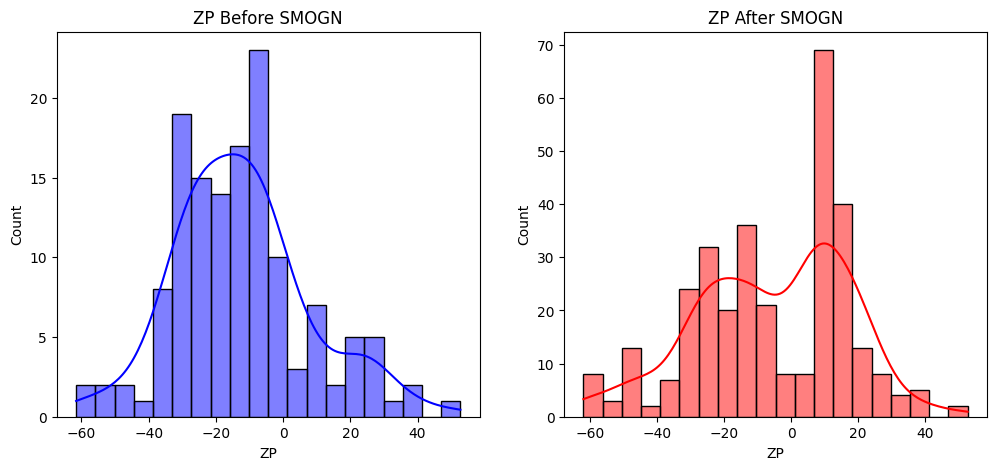

In [ ]:
plt.figure(figsize=(12, 5))

# Before SMOGN
plt.subplot(1, 2, 1)
sns.histplot(df_smogn_input["ZP"], bins=20, kde=True, color='blue')
plt.title("ZP Before SMOGN")

# After SMOGN
plt.subplot(1, 2, 2)
sns.histplot(df_smogn["ZP"], bins=20, kde=True, color='red')
plt.title("ZP After SMOGN")

plt.show()

Before SMOGN:
count    139.000000
mean       9.923876
std       38.358221
min      -70.900911
25%       -4.881274
50%        6.819139
75%       17.852867
max      260.000516
Name: ALT%, dtype: float64

After SMOGN:
count    323.000000
mean      30.200507
std       50.442250
min      -60.000000
25%        7.524288
50%       13.730570
75%       48.887038
max      261.191861
Name: ALT%, dtype: float64


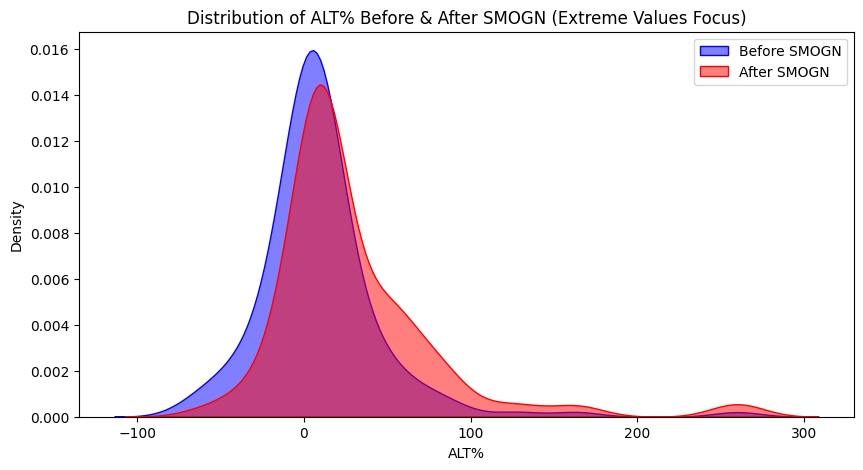

/tmp/ipython-input-527117558.py:24: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[y_original, y_resampled], palette=["blue", "red"])


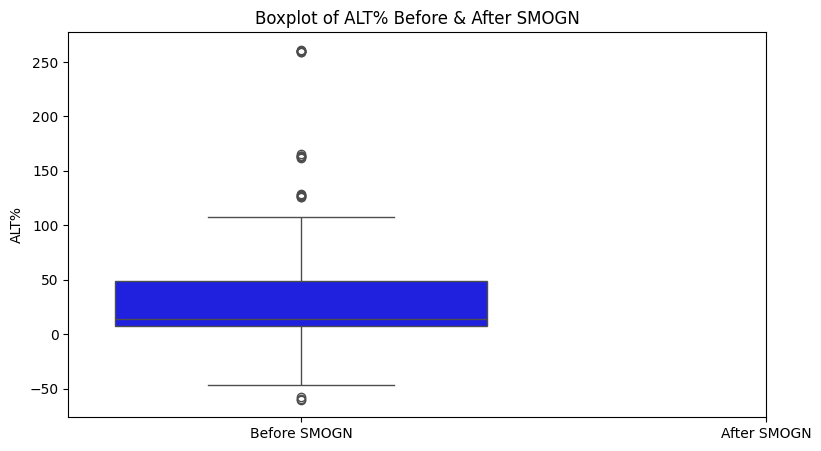

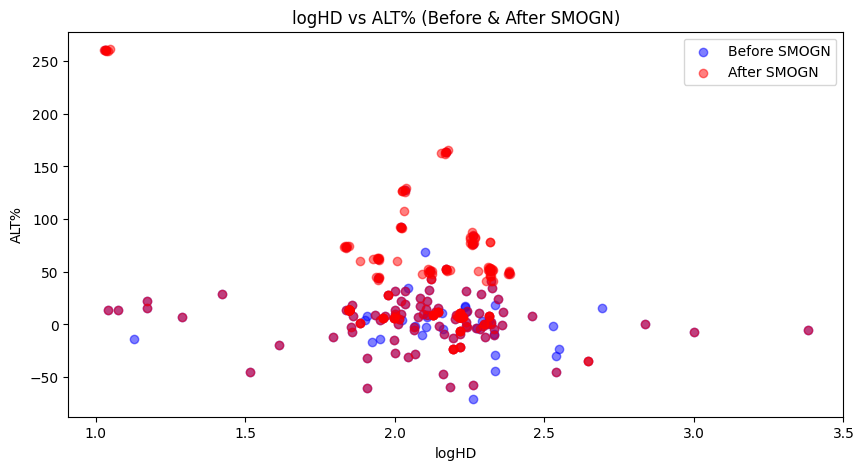

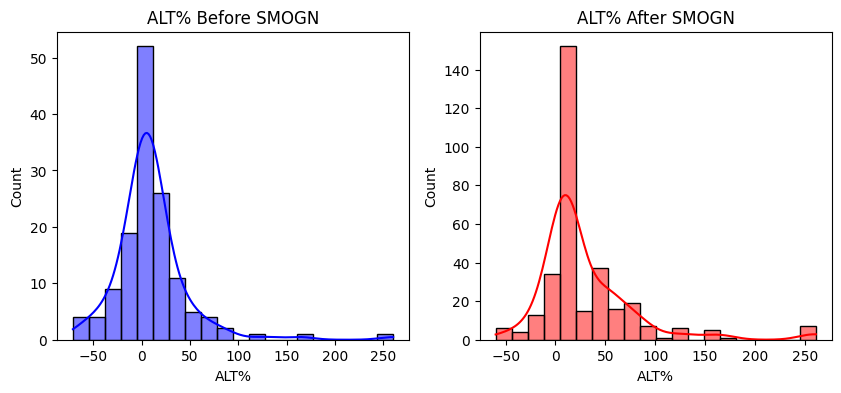

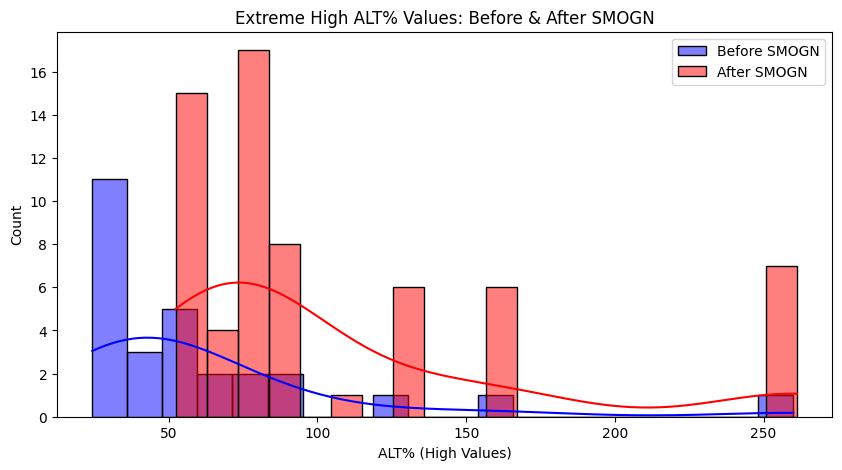

In [ ]:
#Examine the distributions before and after SMOGN
# ✅ Extract target variable
y_original = df_smogn_input["ALT%"]
y_resampled = df_smogn["ALT%"]

print("Before SMOGN:")
print(df_smogn_input["ALT%"].describe())

print("\nAfter SMOGN:")
print(df_smogn["ALT%"].describe())

# 🔹 **1. KDE Plot: Distribution of ALT% Before and After SMOGN**
plt.figure(figsize=(10, 5))
sns.kdeplot(y_original, label="Before SMOGN", fill=True, color='blue', alpha=0.5)
sns.kdeplot(y_resampled, label="After SMOGN", fill=True, color='red', alpha=0.5)
plt.title("Distribution of ALT% Before & After SMOGN (Extreme Values Focus)")
plt.xlabel("ALT%")
plt.ylabel("Density")
plt.legend()
plt.show()

# 🔹 **2. Box Plot: Checking Changes in Extreme ALT% Values**
plt.figure(figsize=(9, 5))
sns.boxplot(data=[y_original, y_resampled], palette=["blue", "red"])
plt.xticks([0, 1], ["Before SMOGN", "After SMOGN"])
plt.title("Boxplot of ALT% Before & After SMOGN")
plt.ylabel("ALT%")
plt.show()

# 🔹 **3. Scatter Plot: Feature vs ALT%**
plt.figure(figsize=(10, 5))
plt.scatter(df_smogn_input.iloc[:, 0], y_original, color='blue', alpha=0.5, label="Before SMOGN")
plt.scatter(df_smogn.iloc[:, 0], y_resampled, color='red', alpha=0.5, label="After SMOGN")
plt.xlabel(df_smogn_input.columns[0])  # Use first feature for visualization
plt.ylabel("ALT%")
plt.title(f"{df_smogn_input.columns[0]} vs ALT% (Before & After SMOGN)")
plt.legend()
plt.show()

# 🔹 **4. Histogram: Value Counts Before & After**
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(y_original, bins=20, kde=True, color='blue')
plt.title("ALT% Before SMOGN")

plt.subplot(1, 2, 2)
sns.histplot(y_resampled, bins=20, kde=True, color='red')
plt.title("ALT% After SMOGN")

plt.show()

# 🔹 **5. Zoom In: Focus on High ALT% (Above 80th Percentile)**
plt.figure(figsize=(10, 5))
sns.histplot(y_original[y_original > np.percentile(y_original, 80)], bins=20, kde=True, color='blue', label="Before SMOGN")
sns.histplot(y_resampled[y_resampled > np.percentile(y_resampled, 80)], bins=20, kde=True, color='red', label="After SMOGN")
plt.title("Extreme High ALT% Values: Before & After SMOGN")
plt.xlabel("ALT% (High Values)")
plt.legend()
plt.show()

In [ ]:
#Save SMOGN dataset
df_smogn.to_csv(os.path.join(root_dir + project_folder, "SMOGN dataset_ALT.csv"), index=False)

In [ ]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import os
import seaborn as sns

In [ ]:
#Read saved SMOGN data
df_smogn = pd.read_csv(os.path.join(root_dir + project_folder + "SMOGN dataset_ALT.csv"))

In [ ]:
df = df_smogn.copy()
df.shape

(220, 33)

In [ ]:
df.columns

Index(['logHD', 'ZP', 'AccumDose', 'PT_Inorganic', 'PT_Organic', 'MAT_Gold',
       'MAT_Hybrid', 'MAT_Hydrogel', 'MAT_Inorganic others', 'MAT_Iron',
       'MAT_Liposome', 'MAT_Organic others', 'MAT_Polymeric', 'MAT_Silica',
       'Shape_Plate', 'Shape_Rod', 'Shape_Spherical', 'TS_Passive',
       'TM_Allograft Orthotopic', 'TM_Healthy', 'TM_Xenograft Heterotopic',
       'TM_Xenograft Orthotopic', 'Cancer_Freproductive', 'Cancer_GI tract',
       'Cancer_Healthy', 'Cancer_Lung', 'Cancer_Mreproductive',
       'Cancer_Others', 'Cancer_Skin', 'AT_YES', 'MM_healthy',
       'CoDelivery_yes', 'ALT%'],
      dtype='object')

In [ ]:
X = df.drop(columns=["ALT%"])
y = df["ALT%"]

In [ ]:
X.shape

(220, 32)

In [ ]:
# Identify continuous and categorical features
continuous_features = ['ZP','AccumDose']

# Split data into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4233)

# Standardize the data
scaler = StandardScaler()
X_train[continuous_features] = scaler.fit_transform(X_train[continuous_features])  # Keep original number of features
X_test[continuous_features] = scaler.transform(X_test[continuous_features])
X_scaled = np.vstack((X_train, X_test))

In [ ]:
joblib.dump(scaler, f'scaler_ALT.pkl')

['scaler_ALT.pkl']

In [ ]:
X_train.shape

(176, 32)

In [ ]:
# Subset Train and Test Data Using Selected Features
X_train_selected = X_train
X_test_selected = X_test
X_scaled = np.vstack((X_train_selected, X_test_selected))

In [ ]:
# Save X_train_selected, X_test_selected and X_scaled
X_train_selected.to_csv(os.path.join(root_dir + project_folder, "X_train_selected_ALT.csv"), index=False)
X_test_selected.to_csv(os.path.join(root_dir + project_folder, "X_test_selected_ALT.csv"), index=False)
X_scaled = pd.DataFrame(X_scaled, columns=selected_features)
X_scaled.to_csv(os.path.join(root_dir + project_folder, "X_scaled_ALT.csv"), index=False)

In [ ]:
# Save y_train and y_test
y_train.to_csv(os.path.join(root_dir + project_folder, "y_train_ALT.csv"), index=False)
y_test.to_csv(os.path.join(root_dir + project_folder, "y_test_ALT.csv"), index=False)

In [6]:
# Load X_train and X_test
X_train_selected = pd.read_csv(os.path.join(root_dir + project_folder, "X_train_selected_ALT.csv"))
X_test_selected = pd.read_csv(os.path.join(root_dir + project_folder, "X_test_selected_ALT.csv"))
X_scaled = pd.read_csv(os.path.join(root_dir + project_folder, "X_scaled_ALT.csv"))
y_train = pd.read_csv(os.path.join(root_dir + project_folder, "y_train_ALT.csv"))
y_test = pd.read_csv(os.path.join(root_dir + project_folder, "y_test_ALT.csv"))
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# **CatBoost Model**

## **Hyperparameter Tuning with Bayesian Optimzation**

In [7]:
!pip install --upgrade numpy catboost --quiet

In [8]:
from catboost import CatBoostRegressor, Pool
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error, root_mean_squared_error as rmse # import rmse
import numpy as np
import pandas as pd
import os

In [9]:
# Define the CatBoost model
models_to_run = [CatBoostRegressor(loss_function='RMSE',
                   random_state=42,
                   verbose=0,
                   early_stopping_rounds=50)]

model_param_search = [{
    'iterations': Integer(100, 5000),
    'learning_rate': Real(0.0001, 0.1, prior='log-uniform'),
    'depth': Integer(4, 6),
    'l2_leaf_reg': Real(1.0, 20.0),
    'subsample': Real(0.5, 1),
    'rsm': Real(0.7, 1.0)
}]

## **Model Training and Evaluation**

In [11]:
# ✅ Define KFold Cross-Validation
cv = KFold(n_splits=5, shuffle=True, random_state=77)

#Store all CV results
catb_cv_results = []

# ✅ Run Bayesian Search for CatBoost
print(f"\nRunning Bayesian Search for CatBoost Model...")

fit_params = {
    "eval_set":[(X_test_selected, y_test)],
    "early_stopping_rounds": 50,
    "eval_metric": "RMSE",
    "verbose": 0
}

bs = BayesSearchCV(
    estimator=models_to_run[0],
    search_spaces=model_param_search,
    cv=cv,
    n_iter=80,
    n_jobs=-1,
    scoring="r2",
    return_train_score=True,
    random_state=47,
    error_score="raise",
    fit_params=fit_params
    )

# ✅ Fit the model
bs.fit(X_train_selected, y_train)

# ✅ Extract the best model
catb_model = bs.best_estimator_
test_preds = catb_model.predict(X_test_selected)
train_preds = catb_model.predict(X_train_selected)
all_preds = catb_model.predict(X_scaled)
y = np.concatenate([y_train, y_test]) # Define y by concatenating y_train and y_test

# ✅ Cross-validation scores
r2_kfolds = cross_val_score(catb_model, X_train_selected, y_train, cv=cv, n_jobs=-1, scoring='r2')
rmse_kfolds = cross_val_score(catb_model, X_train_selected, y_train, cv=cv, n_jobs=-1, scoring='neg_root_mean_squared_error')

# ✅ Overall R2 for combined train and test
r2_all = r2_score(np.hstack([y_train.squeeze(), y_test.squeeze()]), np.hstack([train_preds, test_preds]))

print('\nThe 5-CV RMSE Score was:', -rmse_kfolds.mean())
print('With a standard deviation of:', rmse_kfolds.std())
print('Test RMSE Score: %.2f' % rmse(y_test, test_preds))

print('\nThe 5-CV R2 Score was:', r2_kfolds.mean())
print('With a standard deviation of:', r2_kfolds.std())
print("Test R2 Score : %.2f" % r2_score(y_test, test_preds))
print("Train R2 Score : %.2f" % r2_score(y_train, train_preds))
print("All R2 Score : %.2f" % r2_all)
print("Train RMSE Score: %.2f" % rmse(y_train, train_preds))


print("Fitting completed.")


Running Bayesian Search for CatBoost Model...


ValueError: Found input variables with inconsistent numbers of samples: [232, 256]

In [ ]:
for fold, (train_idx, test_idx) in enumerate(cv.split(X_train_selected), 1):
    X_tr, X_te = X_train_selected.iloc[train_idx], X_train_selected.iloc[test_idx]
    y_tr, y_te = y_train[train_idx], y_train[test_idx]

    catb_model.fit(X_tr, y_tr)
    y_pred = catb_model.predict(X_te)

    for true_val, pred_val in zip(y_te, y_pred):
        catb_cv_results.append({
            "Fold": fold,
            "True": true_val,
            "Predicted": pred_val,
            "Residual": true_val - pred_val
            })

cv_results_df = pd.DataFrame(catb_cv_results)
cv_results_df.to_csv("Catb_cv_fold_predictions_model_comparison_ALT.csv", index=False)

In [ ]:
# ✅ Print metrics
print('\nThe 5-CV RMSE Score was:', -rmse_kfolds.mean())
print('With a standard deviation of:', rmse_kfolds.std())
print('Test RMSE Score: %.2f' % rmse(y_test, test_preds))

print('\nThe 5-CV R2 Score was:', r2_kfolds.mean())
print('With a standard deviation of:', r2_kfolds.std())
print("Test R2 Score : %.2f" % r2_score(y_test, test_preds))
print("Train R2 Score : %.2f" % r2_score(y_train, train_preds))
print("All R2 Score : %.2f" % r2_all)
print("Train RMSE Score: %.2f" % rmse(y_train, train_preds))


The 5-CV RMSE Score was: 28.44817107029504
With a standard deviation of: 8.116281173005778
Test RMSE Score: 23.57

The 5-CV R2 Score was: 0.6964491448744974
With a standard deviation of: 0.14279080919481157
Test R2 Score : 0.72
Train R2 Score : 0.97
All R2 Score : 0.94
Train RMSE Score: 9.23


In [ ]:
# Best model and parameters
catb_model = bs.best_estimator_
catb_best_params = bs.best_params_

print("\n✅ Best Model:", catb_model)
print("\n✅ Best Hyperparameters:")
for param, value in catb_best_params.items():
    print(f"{param}: {value}")


✅ Best Model: <catboost.core.CatBoostRegressor object at 0x7a94050518d0>

✅ Best Hyperparameters:
depth: 6
iterations: 100
l2_leaf_reg: 1.0
learning_rate: 0.1
rsm: 1.0
subsample: 0.5


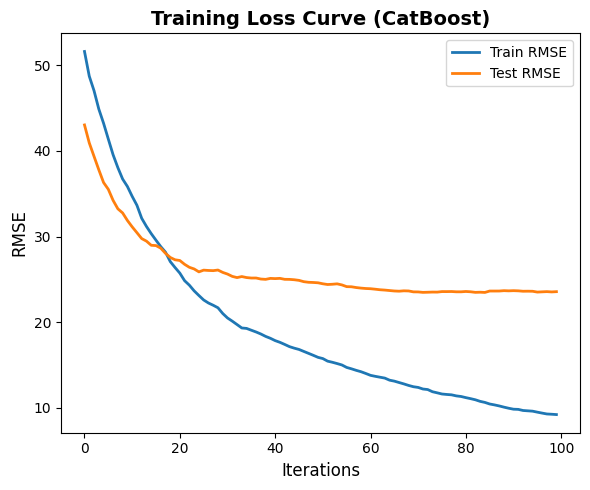

In [ ]:
import matplotlib.pyplot as plt

# ✅ Create Pools for train and validation sets
train_pool = Pool(X_train_selected, y_train)
valid_pool = Pool(X_test_selected, y_test)

# ✅ Fit the model
catb_model.fit(
    train_pool,
    eval_set=valid_pool,
    use_best_model=True
)

# ✅ Retrieve learning curves
eval_results = catb_model.get_evals_result()
train_rmse = eval_results['learn']['RMSE']
test_rmse = eval_results['validation']['RMSE']

# ✅ Plot the RMSE loss curves
plt.figure(figsize=(6, 5))
plt.plot(train_rmse, label="Train RMSE", linewidth=2)
plt.plot(test_rmse, label="Test RMSE", linewidth=2)
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.title("Training Loss Curve (CatBoost)", fontsize=14, fontweight="bold")
plt.legend()
plt.tight_layout()
plt.savefig("CatBoost_Training Loss Curve_ALT.tiff", dpi = 300, format = "tiff", bbox_inches = "tight", pad_inches = 0.1)
plt.show()


In [ ]:
print("Best iteration:", catb_model.get_best_iteration())

Best iteration: None


In [ ]:
import joblib
# Define save path
save_path = os.path.join(root_dir + project_folder, "CatBoost_bayes_model_ALT.joblib")

# Save the best estimator
joblib.dump(catb_model, save_path)
print(f"Best model saved at: {save_path}")

Best model saved at: /content/drive/My Drive/Colab Notebooks/SOT-nano-2025/CatBoost_bayes_model_ALT.joblib


In [ ]:
metrics_path = os.path.join(root_dir + project_folder,"CatBoost_metrics_ALT.txt")
with open(metrics_path, "w") as f:
    f.write(f"5-CV RMSE Score: {rmse_kfolds.mean():.4f}\n")
    f.write(f"Standard Deviation of RMSE: {rmse_kfolds.std():.4f}\n")
    f.write(f"Test RMSE Score: {rmse(y_test, test_preds):.4f}\n")
    f.write(f"5-CV R² Score: {r2_kfolds.mean():.4f}\n")
    f.write(f"Standard Deviation of R²: {r2_kfolds.std():.4f}\n")
    f.write(f"Test R² Score: {r2_score(y_test, test_preds):.4f}\n")
    f.write(f"Train R² Score: {r2_score(y_train, train_preds):.4f}\n")
    f.write(f"Overall R² Score: {r2_all:.4f}\n")
    f.write(f"Train RMSE Score: {rmse(y_train, train_preds):.4f}\n")

In [ ]:
# Save prediction on train and test data
# Create a DataFrame with actual and predicted values
predictions_df = pd.DataFrame({
    "Actual": np.hstack([y_train.squeeze(), y_test.squeeze()]),  # Combine train and test actual values
    "Predicted": np.hstack([train_preds, test_preds]),  # Combine predictions
    "Dataset": ["Train"] * len(y_train) + ["Test"] * len(y_test)  # Label data points
})

# Save to CSV
predictions_df.to_csv(os.path.join(root_dir + project_folder,"CatBoost_predictions_ALT.csv"), index=False)

print("Predictions saved to 'CatBoost_predictions_ALT.csv'")

Predictions saved to 'CatBoost_predictions_ALT.csv'


## **Model Evaluation Plots (CatBoost Model)**

In [ ]:
import joblib
import os
from sklearn.metrics import r2_score, auc
from sklearn.metrics import root_mean_squared_error as rmse
import seaborn as sns
import shap
import matplotlib.pyplot as plt
from shap._explanation import group_features

In [ ]:
# Define model path
model_path = os.path.join(root_dir + project_folder, "CatBoost_bayes_model_ALT.joblib")

# Load the trained model
catb_model = joblib.load(model_path)

In [ ]:
# Extract the model parameters
best_params = catb_model.get_params()

In [ ]:
# Define file path
predictions_path = os.path.join(root_dir + project_folder, "CatBoost_predictions_ALT.csv")

# Load the predictions DataFrame
predictions_df = pd.read_csv(predictions_path)

# Extract Train Data
y_train = predictions_df.loc[predictions_df["Dataset"] == "Train", "Actual"].values
train_preds = predictions_df.loc[predictions_df["Dataset"] == "Train", "Predicted"].values

# Extract Test Data
y_test = predictions_df.loc[predictions_df["Dataset"] == "Test", "Actual"].values
test_preds = predictions_df.loc[predictions_df["Dataset"] == "Test", "Predicted"].values

# Print confirmation
print(f" y_train size: {len(y_train)}, train_preds size: {len(train_preds)}")
print(f" y_test size: {len(y_test)}, test_preds size: {len(test_preds)}")

In [ ]:
cv_results_df = pd.read_csv(os.path.join(root_dir + project_folder, "Catb_cv_fold_predictions_model_comparison_ALT.csv"))

fold_curves = []
fold_aucs = []

# Loop through folds in cv_results_df
for fold in sorted(cv_results_df["Fold"].unique()):
    fold_data = cv_results_df[cv_results_df["Fold"] == fold].copy()

    # Sort by predicted values in descending order
    fold_data = fold_data.sort_values("Predicted", ascending=False).reset_index(drop=True)

    # Calculate cumulative gain
    cum_true = fold_data["True"].cumsum()
    gain = cum_true / cum_true.iloc[-1]
    prop_samples = np.linspace(1 / len(gain), 1, len(gain))

    fold_curves.append((prop_samples, gain))
    fold_auc = auc(prop_samples, gain)
    fold_aucs.append(fold_auc)


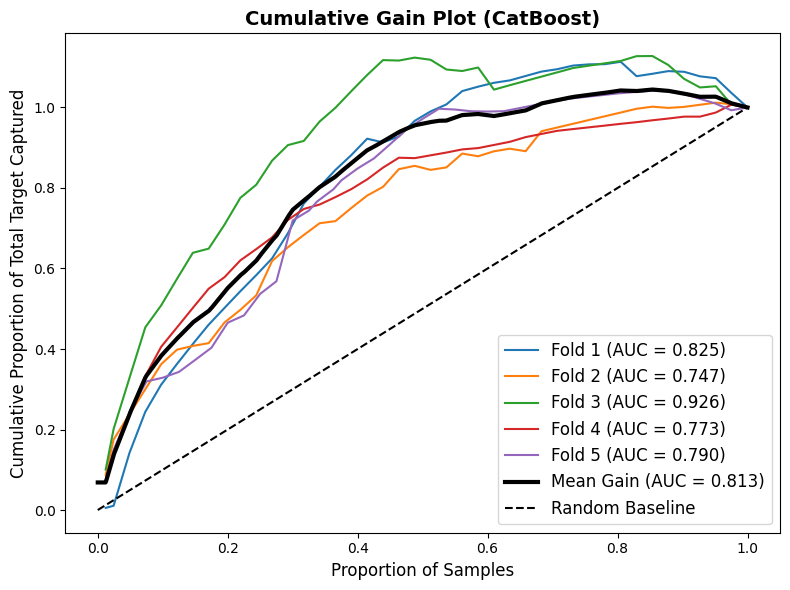

In [ ]:
plt.figure(figsize=(8, 6))
for i, (x, y_) in enumerate(fold_curves):
    plt.plot(x, y_, label=f"Fold {i+1} (AUC = {fold_aucs[i]:.3f})", lw=1.5)

# Mean curve
x_interp = np.linspace(0, 1, 1000)
y_interp = np.mean([np.interp(x_interp, fx, fy) for fx, fy in fold_curves], axis=0)
mean_auc = auc(x_interp, y_interp)
plt.plot(x_interp, y_interp, color='black', lw=3, label=f"Mean Gain (AUC = {mean_auc:.3f})")

# Random baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random Baseline')

# Plot formatting
plt.title("Cumulative Gain Plot (CatBoost)", fontsize=14, fontweight='bold')
plt.xlabel("Proportion of Samples", fontsize=12)
plt.ylabel("Cumulative Proportion of Total Target Captured", fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.tight_layout()

# Save the plot
plt.savefig("CatBoost_Cumulative_Gain_CV_ALT.tiff", dpi=300)

plt.show()

In [ ]:
r2_test = r2_score(y_test, test_preds)  # Test R²
r2_train = r2_score(y_train, train_preds)  # Train R²
r2_all = r2_score(np.concatenate([y_train, y_test]), np.concatenate([train_preds, test_preds]))  # All Data R²

rmse_test = rmse(y_test, test_preds)  # Test RMSE
rmse_train = rmse(y_train, train_preds)  # Train RMSE

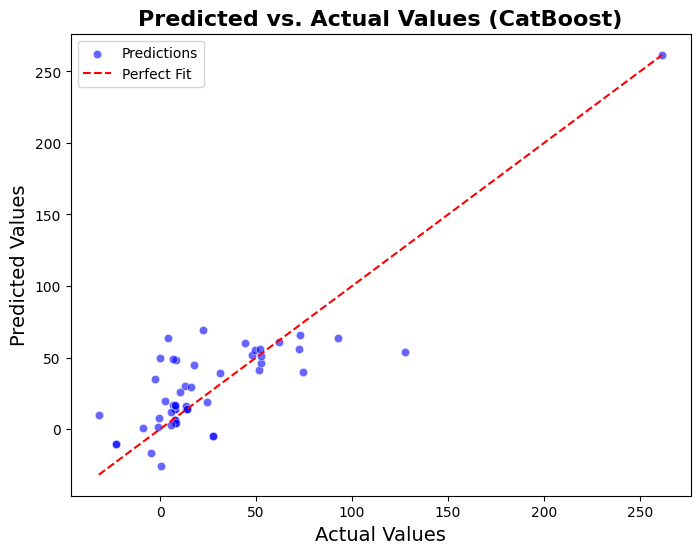

In [ ]:
# ✅ Generate Evaluation Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test.squeeze(), y=test_preds, alpha=0.6, color="blue", label="Predictions")

# ✅ Add Perfect Fit Line (Diagonal)
min_val = min(y_test.squeeze().min(), test_preds.min())
max_val = max(y_test.squeeze().max(), test_preds.max())
plt.plot([min_val, max_val], [min_val, max_val], '--', color="red", label="Perfect Fit")

plt.xlabel("Actual Values", fontsize=14)
plt.ylabel("Predicted Values", fontsize=14)
plt.title("Predicted vs. Actual Values (CatBoost)", fontsize=16, fontweight="bold")
plt.legend()

#save this figure as tiff format
plt.savefig("Catboost_Scatterplot of R score for the test set_ALT.tiff", dpi = 300, format = "tiff", bbox_inches = "tight", pad_inches = 0.1)

plt.show()

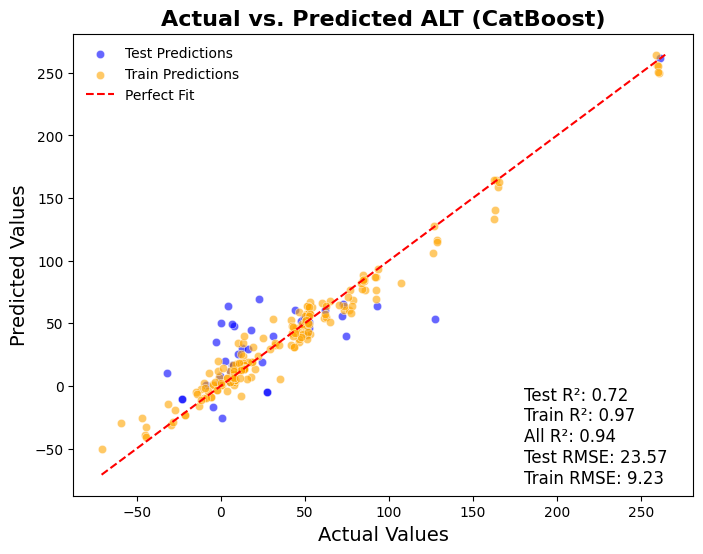

In [ ]:
3 # ✅ Generate Scatter Plot for Train & Test Data
plt.figure(figsize=(8, 6))

# 🔹 Test Data (Blue)
sns.scatterplot(x=y_test.squeeze(), y=test_preds, alpha=0.6, color="blue", label="Test Predictions")

# 🔹 Training Data (Orange)
sns.scatterplot(x=y_train.squeeze(), y=train_preds, alpha=0.6, color="orange", label="Train Predictions")

# 🔹 Perfect Fit Line (Red Dashed)
min_val = min(y_test.squeeze().min(), test_preds.min(), y_train.squeeze().min(), train_preds.min())
max_val = max(y_test.squeeze().max(), test_preds.max(), y_train.squeeze().max(), train_preds.max())
plt.plot([min_val, max_val], [min_val, max_val], '--', color="red", label="Perfect Fit")

# 🔹 Add R² and RMSE Labels at the Bottom Right Corner
text_x = max_val - 0.25 * (max_val - min_val)  # Position slightly left
text_y = min_val - 0.02 * (max_val - min_val)  # Position slightly above the bottom
plt.text(text_x, text_y,
     f"Test R²: {r2_test:.2f}\n"
     f"Train R²: {r2_train:.2f}\n"
     f"All R²: {r2_all:.2f}\n"
     f"Test RMSE: {rmse_test:.2f}\n"
     f"Train RMSE: {rmse_train:.2f}",
     fontsize=12)

# 🔹 Formatting
plt.xlabel("Actual Values", fontsize=14)
plt.ylabel("Predicted Values", fontsize=14)
plt.title("Actual vs. Predicted ALT (CatBoost)", fontsize=16, fontweight="bold")
plt.legend(frameon = False)
plt.grid(False)

#save this figure as tiff format
plt.savefig("Catboost_Scatterplot of R score for the full dataset_ALT.tiff", dpi = 300, format = "tiff", bbox_inches = "tight", pad_inches = 0.1)

plt.show()

In [ ]:
# Initialize SHAP Explainer with the Best Model
explainer = shap.Explainer(catb_model, X_train_selected)

X_test_selected = X_test_selected[X_train_selected.columns]

# Compute SHAP Values for test set
shap_values = explainer(X_test_selected, check_additivity=False)
shap_importance = np.abs(shap_values.values).mean(axis=0)

feature_map = {
    col: col.split("_")[0] if "_" in col else col
    for col in shap_values.feature_names
}
grouped_shap = group_features(shap_values, feature_map)

# Calculate shap_feature_order before using it
shap_feature_order = np.array(grouped_shap.feature_names)[np.argsort(np.abs(grouped_shap.values).mean(0))][::-1]

feature_importance_df = pd.DataFrame({
    "Feature": grouped_shap.feature_names,
    "Mean SHAP": np.abs(grouped_shap.values).mean(axis=0)
})

feature_importance_df = (
    feature_importance_df.set_index("Feature")
    .loc[shap_feature_order]
    .reset_index()
)

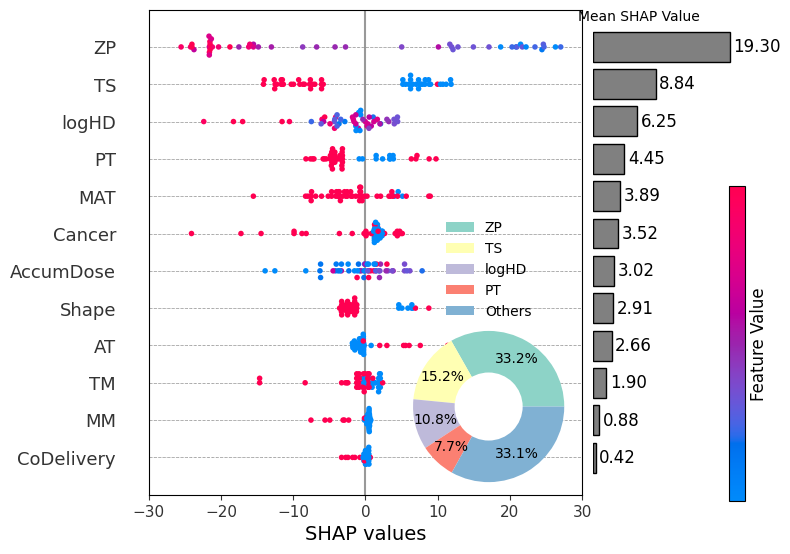

In [ ]:
from matplotlib import gridspec

# ✅ Create Figure Layout (SHAP on Left, Feature Importance in Middle, Color Bar on Right)
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 0.9])  # SHAP summary and Barplot

# ✅ Generate SHAP Summary Plot (Left Side)
ax_shap = fig.add_subplot(gs[0])
shap.plots.beeswarm(grouped_shap, max_display=grouped_shap.shape[1], show=False, color_bar=False)
ax_shap.set_xlabel("SHAP values", fontsize=14)
ax_shap.set_xlim(-30,30)
current_ax = plt.gca()
fig.axes[0] = current_ax

# ✅ Keep the plot border of the SHAP summary plot
ax_shap.spines["top"].set_visible(True)
ax_shap.spines["right"].set_visible(True)
ax_shap.spines["left"].set_visible(True)
ax_shap.spines["bottom"].set_visible(True)

ax_shap.grid(True, axis = "y", linestyle = "--", linewidth = 0.6, color = "gray", alpha = 0.7)

# ✅ Extract Feature Order from SHAP Summary Plot
shap_feature_order = X_test_selected.columns[np.argsort(np.abs(grouped_shap.values).mean(0))[::-1]]

# ✅ Generate Mean SHAP Values as a Bar Chart
ax_bar = fig.add_axes([0.68, 0.11, 0.18, 0.77])
bars = ax_bar.barh(feature_importance_df["Feature"], feature_importance_df["Mean SHAP"], color="gray", edgecolor = "black")

for bar in bars:
    width = bar.get_width()  # Get bar length (SHAP value)
    ax_bar.text(
        width + 0.5,  # Small offset to the right
        bar.get_y() + bar.get_height()/2,  # Center text vertically
        f"{width:.2f}",  # Format value with 3 decimal places
        ha='left', va='center', fontsize=12, color="black"
    )

# ✅ Move X-Axis Title Manually (Adjusted for Visibility)
ax_bar.set_xlabel("Mean SHAP Value", labelpad=12)
ax_bar.xaxis.set_label_coords(0.32, 1)  # Fine-tuned placement

# ✅ Remove X-axis labels
ax_bar.set_xticklabels([])  # Remove x-axis labels
ax_bar.invert_yaxis()    # Ensure the order matches the SHAP summary plot
ax_bar.set_yticklabels([])  # Remove feature names from Y-axis
ax_bar.set_xticks([])    # Remove x-axis ticks
ax_bar.set_yticks([])    # Remove y-axis ticks

# ✅ Remove the border (spines) of the bar plot
ax_bar.spines["top"].set_visible(False)
ax_bar.spines["right"].set_visible(False)
ax_bar.spines["left"].set_visible(False)
ax_bar.spines["bottom"].set_visible(False)

# ✅ Manually Add the Color Bar (Optimized Position)
ax_colorbar = fig.add_axes([0.85, 0.1, 0.02, 0.5])  # [left, bottom, width, height]
shap_colormap = shap.plots.colors.red_blue
sm = plt.cm.ScalarMappable(cmap=shap_colormap)  # Define SHAP color map
cbar = plt.colorbar(sm, cax=ax_colorbar, orientation="vertical")
cbar.set_label("Feature Value", fontsize=12)

# ✅ Remove Y-Axis Labels and Ticks from Color Bar
cbar.ax.set_yticklabels([])  #  Remove tick labels
cbar.ax.yaxis.set_ticks([])  #  Remove ticks

# ✅ Remove the Border from the Color Bar
cbar.ax.spines["top"].set_visible(False)
cbar.ax.spines["right"].set_visible(False)
cbar.ax.spines["left"].set_visible(False)
cbar.ax.spines["bottom"].set_visible(False)

# ✅ Manually Add the Donut Chart (Optimized Positioning)
ax_donut = fig.add_axes([0.4, 0.1, 0.3, 0.3])  # Adjusted position for better balance

# ✅ Define Feature Contributions
feature_contributions = feature_importance_df["Mean SHAP"] / feature_importance_df["Mean SHAP"].sum() * 100
top_features = feature_contributions[:4].sum()
other_features = 100 - top_features

sizes = list(feature_contributions[:4]) + [other_features]
labels = list(feature_importance_df["Feature"][:4]) + ["Others"]
colors = sns.color_palette("Set3", len(sizes))

# ✅ Create the Donut Chart
wedges, texts, autotexts = ax_donut.pie(
    sizes,
    autopct='%1.1f%%',  # Display percentage values
    pctdistance=0.73,  # Moves percentage labels outward slightly
    colors=colors
)

# ✅ Adjust font size for better visibility
for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_color("black")

# ✅ Add a White Circle at the Center to Maintain Donut Shape
center_circle = plt.Circle((0, 0), 0.45, fc='white')
ax_donut.add_artist(center_circle)

# ✅ Add a Legend Directly Above the Donut Chart
ax_donut.legend(
    handles=wedges, labels=labels, loc="lower center", bbox_to_anchor=(0.5, 0.9),
    fontsize=10, ncol=1, frameon=False, alignment="right")

plt.show()

In [ ]:
fig.set_size_inches(10, 8)
fig.savefig("CatBoost_Shap feature importance for test set of ALT.tiff", dpi = 300, format = "tiff", bbox_inches = "tight", pad_inches = 0.1)

In [ ]:
import shap
import numpy as np

# Initialize Explainer with Training Data (No Scaling in This Case)
explainer = shap.Explainer(catb_model, X_train_selected)

# Ensure Features are the Same and in the Same Order
X_full = X_full = pd.concat([X_train_selected, X_test_selected]).reset_index(drop=True)

# Disable Additivity Check (If Necessary)
shap_values_full = explainer(X_full, check_additivity=False)  # Disable additivity check

# Proceed to Calculate SHAP Importance
shap_importance = np.abs(shap_values_full.values).mean(axis=0)

feature_map = {
    col: col.split("_")[0] if "_" in col else col
    for col in shap_values_full.feature_names
}
grouped_shap_full = group_features(shap_values_full, feature_map)

# Calculate shap_feature_order before using it
shap_feature_order = np.array(grouped_shap_full.feature_names)[np.argsort(np.abs(grouped_shap_full.values).mean(0))][::-1]

feature_importance_df = pd.DataFrame({
    "Feature": grouped_shap_full.feature_names,
    "Mean SHAP": np.abs(grouped_shap_full.values).mean(axis=0)
})

feature_importance_df = (
    feature_importance_df.set_index("Feature")
    .loc[shap_feature_order]
    .reset_index()
)

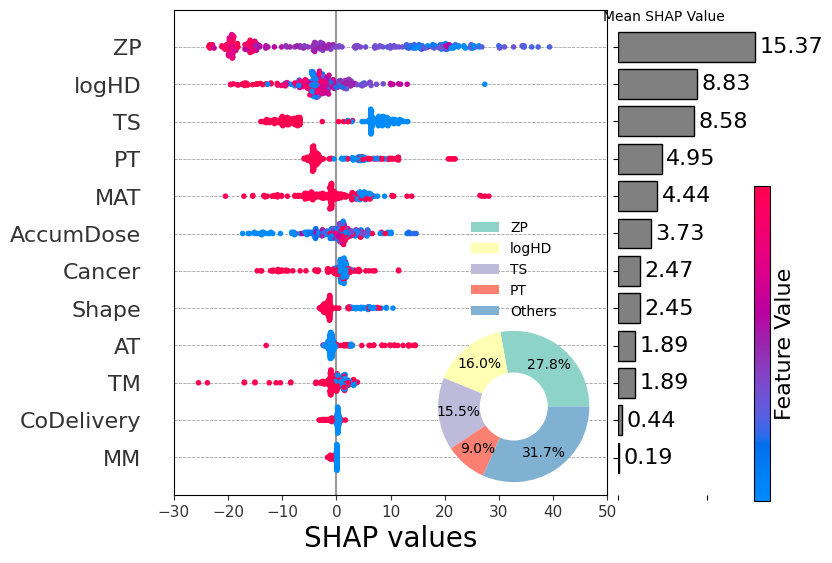

In [ ]:
from matplotlib import gridspec

# ✅ Create Figure Layout (SHAP on Left, Feature Importance in Middle, Color Bar on Right)
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 0.9])  # SHAP summary and Barplot

# ✅ Generate SHAP Summary Plot (Left Side)
ax_shap = fig.add_subplot(gs[0])
shap.plots.beeswarm(grouped_shap_full, max_display=shap_values_full.shape[1], show=False, color_bar=False)
ax_shap.set_xlim(-30, 50)
ax_shap.set_xlabel("SHAP values", fontsize=20)
current_ax = plt.gca()
fig.axes[0] = current_ax

# ✅ Keep the plot border of the SHAP summary plot
ax_shap.spines["top"].set_visible(True)
ax_shap.spines["right"].set_visible(True)
ax_shap.spines["left"].set_visible(True)
ax_shap.spines["bottom"].set_visible(True)

ax_shap.grid(True, axis = "y", linestyle = "--", linewidth = 0.6, color = "gray", alpha = 0.7)

ax_shap.tick_params(axis='y', labelsize=16)

# ✅ Extract Feature Order from SHAP Summary Plot
shap_feature_order = np.array(grouped_shap_full.feature_names)[np.argsort(np.abs(grouped_shap_full.values).mean(0))][::-1]

# ✅ Generate Mean SHAP Values as a Bar Chart
ax_bar = fig.add_axes([0.68, 0.11, 0.18, 0.77])
bars = ax_bar.barh(feature_importance_df["Feature"], feature_importance_df["Mean SHAP"], color="gray", edgecolor = "black")

for bar in bars:
    width = bar.get_width()  # Get bar length (SHAP value)
    ax_bar.text(
        width + 0.5,  # Small offset to the right
        bar.get_y() + bar.get_height()/2,  # Center text vertically
        f"{width:.2f}",  # Format value with 3 decimal places
        ha='left', va='center', fontsize=16, color="black"
    )

# ✅ Move X-Axis Title Manually (Adjusted for Visibility)
ax_bar.set_xlabel("Mean SHAP Value", labelpad=16)
ax_bar.xaxis.set_label_coords(0.32, 1)  # Fine-tuned placement

# ✅ Remove X-axis labels
ax_bar.set_xticklabels([])  # Remove x-axis labels
ax_bar.invert_yaxis()  # Ensure the order matches the SHAP summary plot
ax_bar.set_yticklabels([])  # Remove feature names from Y-axis

# ✅ Remove the border (spines) of the bar plot
ax_bar.spines["top"].set_visible(False)
ax_bar.spines["right"].set_visible(False)
ax_bar.spines["left"].set_visible(False)
ax_bar.spines["bottom"].set_visible(False)

# ✅ Manually Add the Color Bar (Optimized Position)
ax_colorbar = fig.add_axes([0.85, 0.1, 0.02, 0.5])  # [left, bottom, width, height]
shap_colormap = shap.plots.colors.red_blue
sm = plt.cm.ScalarMappable(cmap=shap_colormap)  # Define SHAP color map
cbar = plt.colorbar(sm, cax=ax_colorbar, orientation="vertical")
cbar.set_label("Feature Value", fontsize=16)

# ✅ Remove Y-Axis Labels and Ticks from Color Bar
cbar.ax.set_yticklabels([])  #  Remove tick labels
cbar.ax.yaxis.set_ticks([])  #  Remove ticks

# ✅ Remove the Border from the Color Bar
cbar.ax.spines["top"].set_visible(False)
cbar.ax.spines["right"].set_visible(False)
cbar.ax.spines["left"].set_visible(False)
cbar.ax.spines["bottom"].set_visible(False)

# ✅ Manually Add the Donut Chart (Optimized Positioning)
ax_donut = fig.add_axes([0.4, 0.1, 0.3, 0.3])  # Adjusted position for better balance

# ✅ Define Feature Contributions
feature_contributions = feature_importance_df["Mean SHAP"] / feature_importance_df["Mean SHAP"].sum() * 100
top_features = feature_contributions[:4].sum()
other_features = 100 - top_features

# Define readable labels
custom_label_map = {
    "logHD": "logHD",
    "ZP": "ZP"
}
sizes = list(feature_contributions[:4]) + [other_features]
original_labels = list(feature_importance_df["Feature"][:4]) + ["Others"]
labels = [custom_label_map.get(label, label) for label in original_labels]
colors = sns.color_palette("Set3", len(sizes))


# ✅ Create the Donut Chart
wedges, texts, autotexts = ax_donut.pie(
    sizes,
    autopct='%1.1f%%',  # Display percentage values
    pctdistance=0.73,  # Moves percentage labels outward slightly
    colors=colors
)

# ✅ Adjust font size for better visibility
for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_color("black")

# ✅ Add a White Circle at the Center to Maintain Donut Shape
center_circle = plt.Circle((0, 0), 0.45, fc='white')
ax_donut.add_artist(center_circle)

# ✅ Add a Legend Directly Above the Donut Chart
ax_donut.legend(
    handles=wedges, labels=labels, loc="lower center", bbox_to_anchor=(0.5, 0.9),
    fontsize=10, ncol=1, frameon=False, alignment="right")

plt.show()

In [ ]:
fig.set_size_inches(10, 8)
fig.savefig("CatBoost_Shap feature importance for full dataset of ALT.tiff", dpi = 300, format = "tiff", bbox_inches = "tight", pad_inches = 0.1)

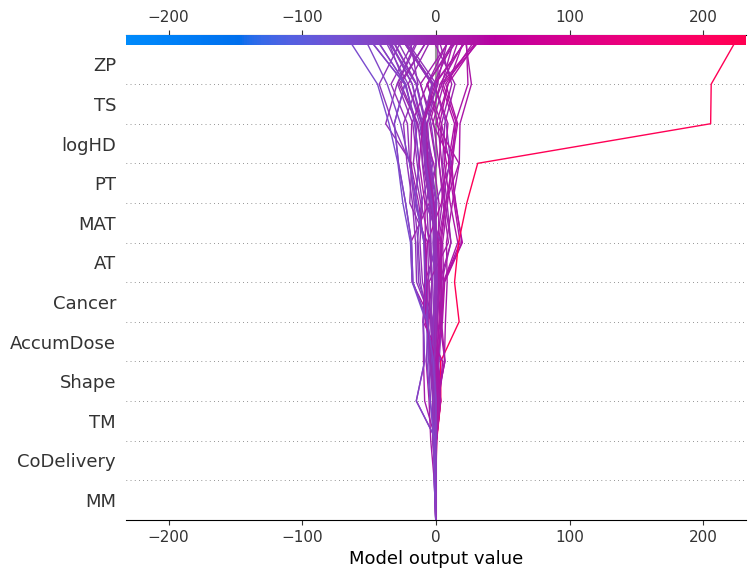

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# ✅ Ensure SHAP values are computed correctly
explainer = shap.Explainer(catb_model, X_train_selected)  # Ensure correct initialization
shap_values = explainer(X_test_selected, check_additivity=False)  # Compute SHAP values properly

feature_map = {
    col: col.split("_")[0] if "_" in col else col
    for col in shap_values.feature_names
}
grouped_shap = group_features(shap_values, feature_map)

# Calculate shap_feature_order before using it
shap_feature_order = np.array(grouped_shap.feature_names)[np.argsort(np.abs(grouped_shap.values).mean(0))][::-1]

# ✅ Ensure SHAP JS visualization is enabled (for notebooks)
shap.initjs()

# ✅ Generate Decision Plot using Test Set
plt.figure(figsize=(10, 6))
shap.decision_plot(
    base_value=np.mean(grouped_shap.base_values),  # Extract base_values correctly
    shap_values=grouped_shap.values,  # SHAP values for test set
    features=grouped_shap.feature_names,  # Test set feature values
    feature_names=grouped_shap.feature_names,  # Feature names
    show=False
)
plt.savefig("CatBoost_Shap Decision plot for test set_ALT.tiff", dpi = 300, format = "tiff", bbox_inches = "tight", pad_inches = 0.1)
# ✅ Show the plot
plt.show()


In [ ]:
# Create DataFrame with SHAP values and corresponding categorical feature values
shap_catb_df = pd.DataFrame(shap_values_full.values, columns=X_test_selected.columns)
shap_catb_df["MM_healthy"] = X_full["MM_healthy"].values  # Add categorical feature (Mouse Model)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Step 2: Compute mean SHAP value per category
shap_by_category_mm = shap_catb_df.groupby("MM_healthy").mean().reset_index()

# Step 3: Use LabelEncoder to map numerical values back to original categories
label_encoder = LabelEncoder()

# Fit the LabelEncoder with the original categories
label_encoder.fit(["healthy", "tumor-bearing"])

# View the mapping between categories and numerical values
mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", mapping)

# Decode numerical values back to original categories
shap_by_category_mm["MM_healthy"] = label_encoder.inverse_transform(shap_by_category_mm["MM_healthy"].astype(int))

# Interpret the Results
for index, row in shap_by_category_mm.iterrows():
    mm_category = row["MM_healthy"]
    mean_shap_value = row.drop("MM_healthy").mean()  # Compute mean SHAP value for the category
    if mean_shap_value > 0:
        print(f"{mm_category}: Mean SHAP Value = {mean_shap_value:.2f} (Increases AST%)")
    else:
        print(f"{mm_category}: Mean SHAP Value = {mean_shap_value:.2f} (Decreases AST%)")

Label Mapping: {np.str_('healthy'): np.int64(0), np.str_('tumor-bearing'): np.int64(1)}
healthy: Mean SHAP Value = 0.02 (Increases AST%)
tumor-bearing: Mean SHAP Value = -0.16 (Decreases AST%)


In [ ]:
#convert grouped_shap_full to a dataframe
shap_df_full = pd.DataFrame(grouped_shap_full.values, columns = grouped_shap_full.feature_names)

# Identify the one-hot encoded MAT columns
mat_cols = [col for col in X_full.columns if col.startswith('MAT_')]

# Label the MAT
materials_labels = X_full[mat_cols].idxmax(axis=1)
maberials_labels = materials_labels.str.replace("MAT_", "")

#Health conditions
condition_label = np.where(X_full['Cancer_Healthy'] == 1, "Healthy", "Tumor-bearing")

shap_mat_df = pd.DataFrame({
    "MAT": materials_labels,
    "Condition": condition_label,
    "SHAP_MAT": shap_df_full["MAT"]
})

MAT_df = shap_mat_df.groupby(["MAT", "Condition"])['SHAP_MAT'].mean().reset_index()
MAT_df["MAT"] = MAT_df["MAT"].str.replace("MAT_", "")

In [ ]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

materials = shap_mat_df['MAT'].unique()
p_values = []

#Mann-Whitney U test
for mat in materials:
    group = shap_mat_df[shap_mat_df['MAT'] == mat]
    group_healthy = group[group['Condition'] == 'Healthy']['SHAP_MAT']
    group_tumor = group[group['Condition'] == 'Tumor-bearing']['SHAP_MAT']

    if len(group_healthy) > 1 and len(group_tumor) > 1:
        stat, p = mannwhitneyu(group_healthy, group_tumor, alternative='two-sided')
    else:
        p = np.nan  # not enough data
    p_values.append(p)

# Store results
pval_df = pd.DataFrame({
    'Material': materials,
    'p-value': p_values
})

# Apply multiple testing correction (FDR)
pvals_for_corr = pval_df['p-value'].dropna()
rej, adj_pvals, _, _ = multipletests(pvals_for_corr, method='fdr_bh')

# Fill into df
pval_df['adj_p'] = np.nan
pval_df.loc[pvals_for_corr.index, 'adj_p'] = adj_pvals

# Significance annotation
def label_sig(p):
    if pd.isna(p):
        return 'n/a'
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

pval_df['Significance'] = pval_df['adj_p'].apply(label_sig)

# Sort and preview
pval_df = pval_df.sort_values('p-value')
print(pval_df)

               Material   p-value     adj_p Significance
5            MAT_Silica  0.014794  0.088764           ns
6            MAT_Hybrid  0.449712  0.892501           ns
4         MAT_Polymeric  0.675881  0.892501           ns
1    MAT_Organic others  0.836716  0.892501           ns
0          MAT_Hydrogel  0.881781  0.892501           ns
7  MAT_Inorganic others  0.892501  0.892501           ns
2          MAT_Liposome       NaN       NaN          n/a
3              MAT_Gold       NaN       NaN          n/a
8              MAT_Iron       NaN       NaN          n/a


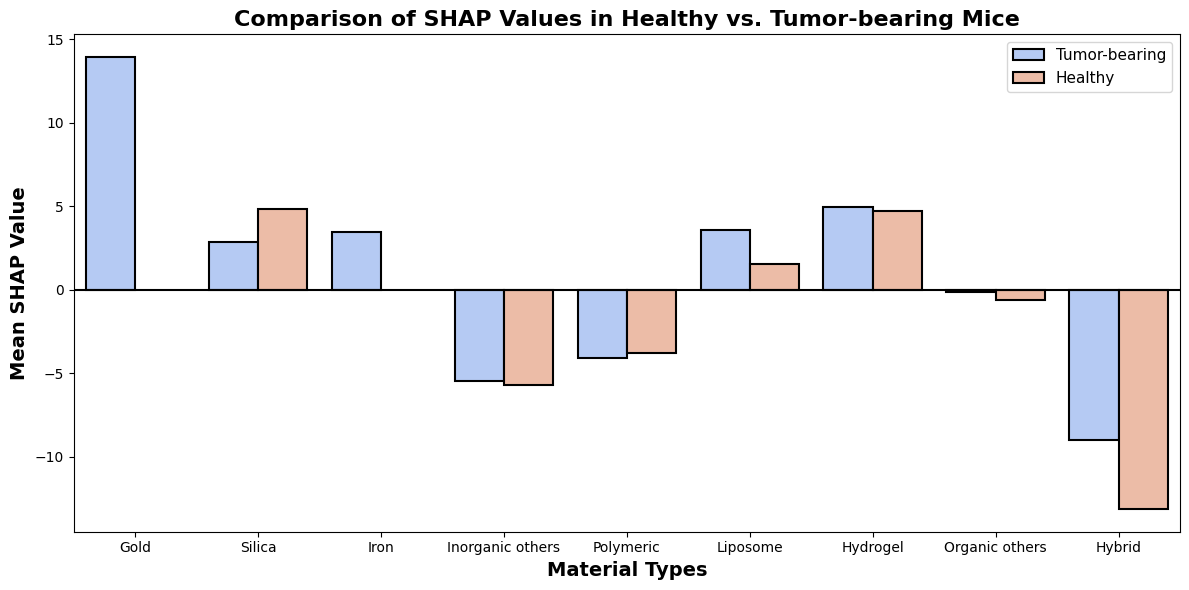

In [ ]:
# Create grouped barplot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data = MAT_df, x="MAT", y="SHAP_MAT", hue="Condition",
                 order = ["Gold", "Silica", "Iron", "Inorganic others", "Polymeric", "Liposome", "Hydrogel", "Organic others", "Hybrid"],
                 palette="coolwarm", edgecolor='black', linewidth=1.5)

# Add horizontal line at y=0
plt.axhline(0, color='black', linewidth=1.5, linestyle='-')

# Add labels and title
plt.xlabel("Material Types", fontsize=14, fontweight='bold')
plt.ylabel("Mean SHAP Value", fontsize=14, fontweight='bold')
plt.title("Comparison of SHAP Values in Healthy vs. Tumor-bearing Mice", fontsize=16, fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=0, ha='center')

# Show the plot
plt.tight_layout()
plt.legend(loc='upper right',bbox_to_anchor=(1, 1),
    fontsize=11,
    frameon=True)
plt.savefig("CatBoost_Comparison between SHAP values by different health model and materials for full dataset_ALT.tiff", dpi = 300, format = "tiff", bbox_inches = "tight", pad_inches = 0.1)

plt.show()

In [ ]:
# Identify the one-hot encoded TS columns
PT_cols = ['PT_Inorganic', 'PT_Organic', 'MAT_Hybrid']

# Label the MAT
PT_labels = X_full[PT_cols].idxmax(axis=1)
PT_labels = PT_labels.str.replace("PT_", "")
PT_labels = PT_labels.str.replace("MAT_", "")

#Health conditions
condition_label = np.where(X_full['Cancer_Healthy'] == 1, "Healthy", "Tumor-bearing")

shap_pt_df = pd.DataFrame({
    "PT": PT_labels,
    "Condition": condition_label,
    "SHAP_PT": shap_df_full["PT"]
})

PT_df = shap_pt_df.groupby(["PT", "Condition"])['SHAP_PT'].mean().reset_index()

In [ ]:
PT = shap_pt_df['PT'].unique()
p_values = []

#Mann-Whitney U test
for pt in PT:
    group = shap_pt_df[shap_pt_df['PT'] == pt]
    group_healthy = group[group['Condition'] == 'Healthy']['SHAP_PT']
    group_tumor = group[group['Condition'] == 'Tumor-bearing']['SHAP_PT']

    if len(group_healthy) > 1 and len(group_tumor) > 1:
        stat, p = mannwhitneyu(group_healthy, group_tumor, alternative='two-sided')
    else:
        p = np.nan  # not enough data
    p_values.append(p)

# Store results
pval_df = pd.DataFrame({
    'PT': PT,
    'p-value': p_values
})

# Apply multiple testing correction (FDR)
pvals_for_corr = pval_df['p-value'].dropna()
rej, adj_pvals, _, _ = multipletests(pvals_for_corr, method='fdr_bh')

# Fill into df
pval_df['adj_p'] = np.nan
pval_df.loc[pvals_for_corr.index, 'adj_p'] = adj_pvals

# Significance annotation
def label_sig(p):
    if pd.isna(p):
        return 'n/a'
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

pval_df['Significance'] = pval_df['adj_p'].apply(label_sig)

# Sort and preview
pval_df = pval_df.sort_values('p-value')
print(pval_df)

          PT   p-value     adj_p Significance
0  Inorganic  0.043902  0.131705           ns
2     Hybrid  0.160377  0.240565           ns
1    Organic  0.355753  0.355753           ns


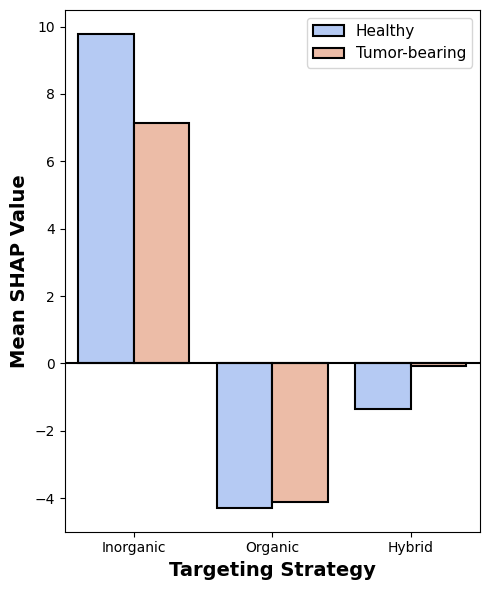

In [ ]:
# Create grouped barplot
plt.figure(figsize=(5, 6))
ax = sns.barplot(data=PT_df, x="PT", y="SHAP_PT", hue="Condition",
                 order = ["Inorganic", "Organic", "Hybrid"],
                 palette="coolwarm", edgecolor='black', linewidth=1.5)

# Add horizontal line at y=0
plt.axhline(0, color='black', linewidth=1.5, linestyle='-')

# Add labels and title
plt.xlabel("Targeting Strategy", fontsize=14, fontweight='bold')
plt.ylabel("Mean SHAP Value", fontsize=14, fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=0, ha='center')

# Show the plot
plt.tight_layout()
plt.legend(loc='upper right',bbox_to_anchor=(1, 1),
    fontsize=11,
    frameon=True)
plt.savefig("CatBoost_Comparison between SHAP values by different health model and particle type for full dataset_ALT.tiff", dpi = 300, format = "tiff", bbox_inches = "tight", pad_inches = 0.1)

plt.show()

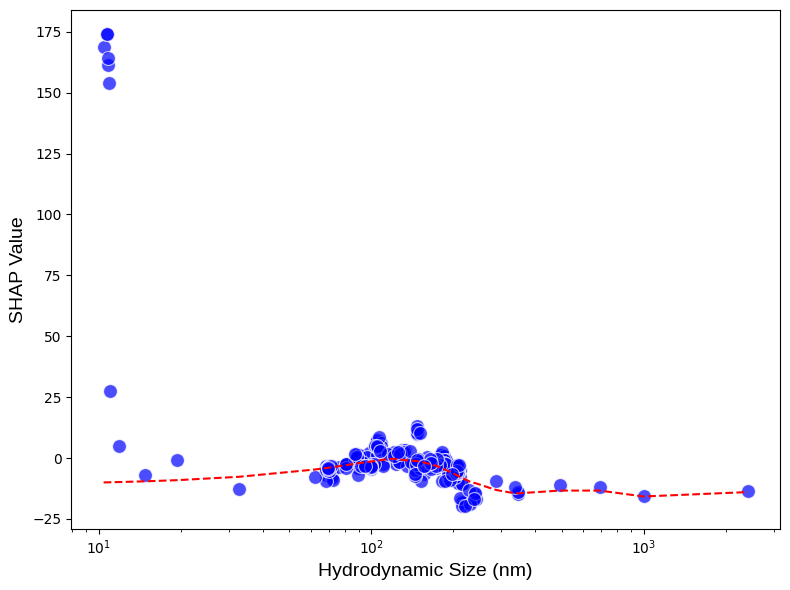

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prepare grouped SHAP data
X_plot = pd.DataFrame(grouped_shap_full.data, columns=grouped_shap_full.feature_names)
shap_df = pd.DataFrame(grouped_shap_full.values, columns=grouped_shap_full.feature_names)

def plot_shap_logHD_linear_scale():
    plt.figure(figsize=(8, 6))

    HD_linear = 10 ** X_plot["logHD"]

    shap_values_logHD = shap_df["logHD"]

    sns.scatterplot(
        x=HD_linear,
        y=shap_values_logHD,
        color = 'blue',
        s = 100,
        alpha=0.7
    )

    # Add trend line (optional)
    import statsmodels.api as sm
    trend = sm.nonparametric.lowess(shap_values_logHD, HD_linear)
    plt.plot(trend[:, 0], trend[:, 1], color='red', linestyle='--', label='Trend')
    plt.xscale('log')
    plt.xlabel("Hydrodynamic Size (nm)", fontsize=14, fontfamily = "Liberation Sans", color = "black")
    plt.ylabel("SHAP Value", fontsize=14, fontfamily = "Liberation Sans", color = "black")
    #plt.title("SHAP Dependence Plot for Hydrodynamic Size", fontsize=16, weight='bold')
    plt.tight_layout()
    plt.show()

plot_shap_logHD_linear_scale()


/tmp/ipython-input-33-1841712430.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [group["SHAP Value"].values for _, group in shap_logHD_df.groupby("Hydrodynamic Size Category")]
/tmp/ipython-input-33-1841712430.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


Kruskal-Wallis Test Statistic: 96.70964076110334
p-value: 9.99466714570534e-22


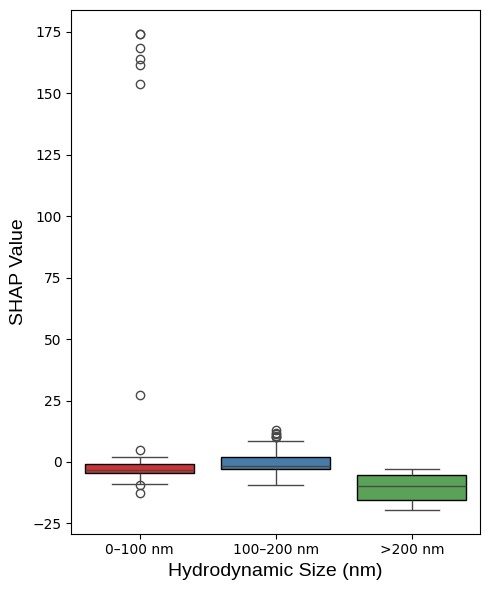

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal

# Convert logHD to linear scale (HD in nm)
HD_linear = 10 ** X_plot["logHD"]

# Define new bins and labels
bins = [0, 100, 200, np.inf]
labels = ['0–100 nm', '100–200 nm', '>200 nm']
HD_categories = pd.cut(HD_linear, bins=bins, labels=labels, include_lowest=True)

# Create DataFrame for analysis
shap_logHD_df = pd.DataFrame({
    "Hydrodynamic Size Category": HD_categories,
    "SHAP Value": shap_df["logHD"]
})

# Statistical test (Kruskal-Wallis)
groups = [group["SHAP Value"].values for _, group in shap_logHD_df.groupby("Hydrodynamic Size Category")]
stat, p = kruskal(*groups)

print(f"Kruskal-Wallis Test Statistic: {stat}")
print(f"p-value: {p}")

# Visualization
plt.figure(figsize=(5, 6))
sns.boxplot(
    data=shap_logHD_df,
    x="Hydrodynamic Size Category",
    y="SHAP Value",
    palette='Set1',
    boxprops=dict(edgecolor='black')
)
plt.xlabel("Hydrodynamic Size (nm)", fontsize=14, fontfamily = "Liberation Sans", color = "black")
plt.ylabel("SHAP Value", fontsize=14, fontfamily = "Liberation Sans", color = "black")
plt.tight_layout()
plt.show()


In [ ]:
import scikit_posthocs as sp

# Dunn’s test with Bonferroni correction
posthoc_results = sp.posthoc_dunn(
    shap_logHD_df,
    val_col='SHAP Value',
    group_col='Hydrodynamic Size Category',
    p_adjust='bonferroni'
)

posthoc_results

,0–100 nm,100–200 nm,>200 nm
0–100 nm,1.000000e+00,6.422267e-04,1.086661e-09
100–200 nm,6.422267e-04,1.000000e+00,2.581296e-22
>200 nm,1.086661e-09,2.581296e-22,1.000000e+00


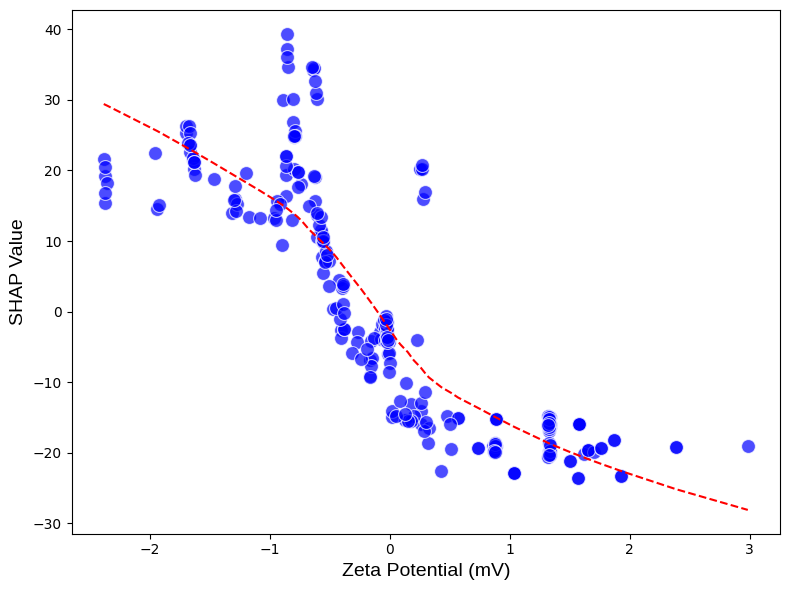

In [ ]:
def plot_shap_ZP():
    plt.figure(figsize=(8, 6))

    shap_values_ZP = shap_df["ZP"]

    sns.scatterplot(
        x = X_plot['ZP'],
        y=shap_values_ZP,
        color = 'blue',
        s = 100,
        alpha=0.7
    )

    # Add trend line
    import statsmodels.api as sm
    trend = sm.nonparametric.lowess(shap_values_ZP, X_plot['ZP'],
                                frac=0.8,
                                it=0)
    plt.plot(trend[:, 0], trend[:, 1], color='red', linestyle='--', label='Trend')

    plt.xlabel("Zeta Potential (mV)", fontsize=14, fontfamily = "Liberation Sans", color = "black")
    plt.ylabel("SHAP Value", fontsize=14, fontfamily = "Liberation Sans", color = "black")
    #plt.title("SHAP Dependence Plot for Hydrodynamic Size", fontsize=16, weight='bold')
    plt.tight_layout()
    plt.show()

plot_shap_ZP()

In [ ]:
#convert grouped_shap_full to a dataframe
shap_df_full = pd.DataFrame(grouped_shap_full.values, columns = grouped_shap_full.feature_names)

# Identify the one-hot encoded MAT columns
mat_cols = [col for col in X_full.columns if col.startswith('MAT_')]

# Label the MAT
materials_labels = X_full[mat_cols].idxmax(axis=1)
maberials_labels = materials_labels.str.replace("MAT_", "")

shap_mat_df = pd.DataFrame({
    "MAT": materials_labels,
    "SHAP_MAT": shap_df_full["MAT"]
})

MAT_df = shap_mat_df.groupby(["MAT"])['SHAP_MAT'].mean().reset_index()
MAT_df["MAT"] = MAT_df["MAT"].str.replace("MAT_", "")

In [ ]:
import scipy.stats as stats
groups = [
    grp["SHAP_MAT"].values
    for _, grp in shap_mat_df.groupby("MAT")
]

# Run Kruskal–Wallis
h_stat, p_value = stats.kruskal(*groups)
print(f"Kruskal–Wallis H = {h_stat:.3f}, p = {p_value:.8f}")


Kruskal–Wallis H = 216.542, p = 0.00000000


In [ ]:
posthoc = sp.posthoc_dunn(
    shap_mat_df,
    val_col="SHAP_MAT",
    group_col="MAT",
    p_adjust="bonferroni"
)
print(posthoc)

                          MAT_Gold    MAT_Hybrid  MAT_Hydrogel  \
MAT_Gold              1.000000e+00  5.224686e-12  1.000000e+00   
MAT_Hybrid            5.224686e-12  1.000000e+00  1.091939e-15   
MAT_Hydrogel          1.000000e+00  1.091939e-15  1.000000e+00   
MAT_Inorganic others  6.926177e-11  1.000000e+00  2.771616e-13   
MAT_Iron              1.000000e+00  3.955075e-02  1.000000e+00   
MAT_Liposome          1.000000e+00  4.284056e-08  1.000000e+00   
MAT_Organic others    8.662862e-05  1.621717e-05  6.513115e-08   
MAT_Polymeric         7.080039e-11  4.288295e-01  2.030132e-24   
MAT_Silica            1.000000e+00  5.874646e-10  1.000000e+00   

                      MAT_Inorganic others  MAT_Iron  MAT_Liposome  \
MAT_Gold                      6.926177e-11  1.000000  1.000000e+00   
MAT_Hybrid                    1.000000e+00  0.039551  4.284056e-08   
MAT_Hydrogel                  2.771616e-13  1.000000  1.000000e+00   
MAT_Inorganic others          1.000000e+00  0.056220  4.094

/tmp/ipython-input-45-148989974.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


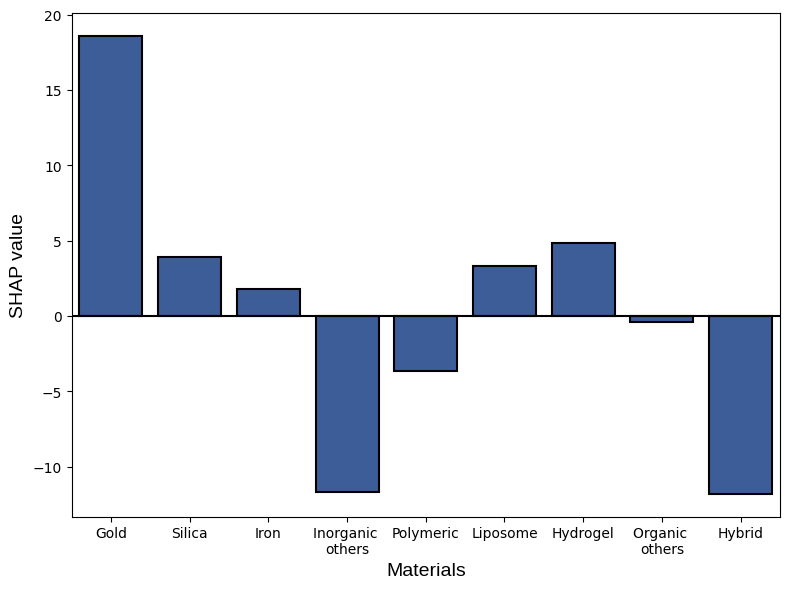

In [ ]:
plt.figure(figsize=(8, 6))

shap_df_full = pd.DataFrame(
    grouped_shap_full.values,
    columns=grouped_shap_full.feature_names
)

# identify one-hot columns for MAT
mat_cols = [c for c in X_full.columns if c.startswith("MAT_")]

materials = (
    X_full[mat_cols]
      .idxmax(axis=1)          # pick the hot one
      .str.replace("MAT_", "") # strip prefix
)

shap_mat_df = pd.DataFrame({
    "MAT": materials,
    "SHAP_MAT": shap_df_full["MAT"]
})
group_stats = (
    shap_mat_df
      .groupby("MAT")["SHAP_MAT"]
      .agg(["mean", "std"])
      .reset_index()
)

ax = sns.barplot(
    x="MAT",
    y="mean",
    data=group_stats,
    color = "#2e59a7",
    order= ['Gold', 'Silica', 'Iron', 'Inorganic others', 'Polymeric', 'Liposome', 'Hydrogel', 'Organic others', 'Hybrid'],
    edgecolor='black',
    linewidth=1.5
)

new_labels = ['Gold', 'Silica', 'Iron', 'Inorganic \nothers', 'Polymeric', 'Liposome','Hydrogel', 'Organic \nothers', 'Hybrid']
ax.set_xticklabels(new_labels)

plt.axhline(0, color='black', linewidth=1.5, linestyle='-')
plt.xlabel("Materials", fontsize=14, fontfamily="Liberation Sans", color = "black")
plt.ylabel("SHAP value", fontsize=14, fontfamily="Liberation Sans", color = "black")
plt.tight_layout()
plt.show()